# Plotting age distributions with respect to genotype groups

0 W:0.9705 p:0.0222 - 102 subjects between 46 and 75
1 W:0.9539 p:0.0769 - 44 subjects between 45 and 71
2 W:0.9613 p:0.0005 - 143 subjects between 45 and 75
3 W:0.9640 p:0.0004 - 160 subjects between 45 and 74
4 W:0.9306 p:0.0013 - 65 subjects between 45 and 67


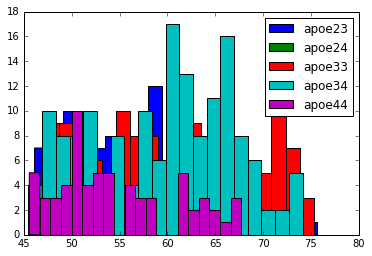

In [4]:
%matplotlib inline
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

data = pd.read_excel('/home/grg/spm/data/covariates.xls')

for i in xrange(5):
    x = data[data['apo'] == i]['age'].values
    plt.hist(x, bins=20)
    print i, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(['apoe23', 'apoe24', 'apoe33', 'apoe34', 'apoe44'])
plt.show()

For two of the 5 groups, the Shapiro test p-value is lower than 1e-3, which means that the distributions of these two groups can't be considered as normal. (But theorically none of them is)

# Matching pairs using nearest neighbours

The matching algorithm:

In [233]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler:
        scaler = StandardScaler()
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])    
    matched = non_treated_df.ix[indices]
    matched = non_treated_df.irow(matched.index)
    return matched

#### Loading data

In [234]:
df = pd.read_excel('/home/grg/spm/data/covariates.xls')
df = df[['subject','apo','age','gender','educyears']]

groups = [df[df['apo']==i] for i in xrange(5)]
for i in xrange(5):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['subject']
    del groups[i]['apo']

### Matching the groups

In [235]:
treated_df =  groups[4]
matched_df = [get_matching_pairs(treated_df, groups[i], scaler=False) for i in xrange(4)]

/home/grg/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


#### Plotting data and see that the groups are now matching

0 W:0.9165 p:0.0003 - 65 subjects between 46 and 66
1 W:0.9271 p:0.0009 - 65 subjects between 45 and 67
2 W:0.9295 p:0.0012 - 65 subjects between 45 and 68
3 W:0.9163 p:0.0003 - 65 subjects between 46 and 68
4 W:0.9306 p:0.0013 - 65 subjects between 45 and 67


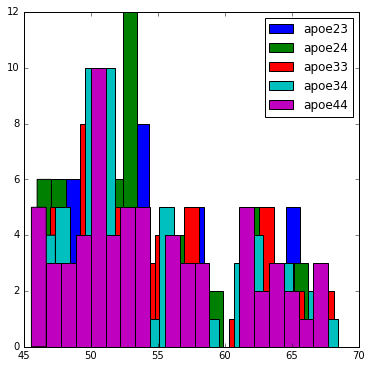

In [236]:
fig, ax = plt.subplots(figsize=(6,6))

for i in xrange(4):
    x = matched_df[i]['age']
    plt.hist(x, bins=20)   
    print i, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))
    
x = treated_df['age']
plt.hist(x, bins=20)   
print 4, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(['apoe23', 'apoe24', 'apoe33', 'apoe34', 'apoe44'])

# Matching groups using linear assignment method

In [6]:
df = pd.read_excel('/home/grg/spm/data/covariates.xls')
df = df[['subject','apo','age','gender','educyears']]

groups = [df[df['apo']==i] for i in xrange(5)]
for i in xrange(5):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['subject']
    del groups[i]['apo']

In [7]:
groups = [df[df['apo']==i] for i in xrange(5)]
for i in xrange(5):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['apo']
    del groups[i]['subject']
treated_df =  groups[4]
non_treated_df = groups[0]

In [8]:
from scipy.spatial.distance import cdist
from scipy import optimize

def get_matching_pairs(treated_df, non_treated_df):
    cost_matrix = cdist(treated_df.values, non_treated_df.values)
    row_ind, col_ind = optimize.linear_sum_assignment(cost_matrix)
    return non_treated_df.iloc[col_ind]

In [9]:
treated_df =  groups[4]
matched_df = [get_matching_pairs(treated_df, groups[i]) for i in xrange(4)]

#### Plotting data and see that the groups are now matching

0 W:0.9200 p:0.0004 - 65 subjects between 46 and 66
1 W:0.9539 p:0.0769 - 44 subjects between 45 and 71
2 W:0.9333 p:0.0017 - 65 subjects between 45 and 68
3 W:0.9411 p:0.0039 - 65 subjects between 45 and 68
4 W:0.9306 p:0.0013 - 65 subjects between 45 and 67


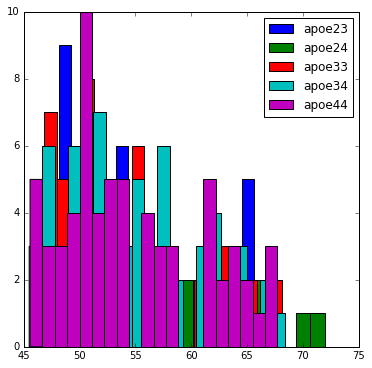

In [10]:
fig, ax = plt.subplots(figsize=(6,6))

for i in xrange(4):
    x = matched_df[i]['age']
    plt.hist(x, bins=20)   
    print i, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))
    
x = treated_df['age']
plt.hist(x, bins=20)   
print 4, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(['apoe23', 'apoe24', 'apoe33', 'apoe34', 'apoe44'])

In [12]:
import json
groups_index = [each.index.tolist() for each in matched_df]
groups_index.append(groups[4].index.tolist())
json.dump(groups_index, open('/tmp/groups.json','w'))